In [1]:
# Install required packages
!pip install open_clip_torch

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import open_clip
import numpy as np
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
from torch.nn.parallel import DataParallel

# Check available GPUs
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"GPU {i} Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.1f} GB")

# Use multiple GPUs if available
if torch.cuda.device_count() > 1:
    device = torch.device("cuda")
    use_multi_gpu = True
    print(f"\n🚀 Using {torch.cuda.device_count()} GPUs!")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_multi_gpu = False
    print(f"\n📱 Using single device: {device}")

CUDA available: True
Number of GPUs: 2
GPU 0: Tesla T4
GPU 0 Memory: 15.8 GB
GPU 1: Tesla T4
GPU 1 Memory: 15.8 GB

🚀 Using 2 GPUs!


In [2]:
class OpenCLIPClassifier(nn.Module):
    """Enhanced OpenCLIP ViT-L/14 model for texture classification."""
    
    def __init__(self, num_classes=47, pretrained=True, mlp_hidden=None, 
                 dropout=0.35, freeze_backbone=True):
        super().__init__()
        
        # Default hidden layers if none provided
        if mlp_hidden is None:
            mlp_hidden = [1024, 512, 256]
        
        # Load pretrained OpenCLIP ViT-L/14 backbone
        if pretrained:
            self.backbone, _, _ = open_clip.create_model_and_transforms(
                'ViT-L-14', 
                pretrained='openai'
            )
        else:
            self.backbone, _, _ = open_clip.create_model_and_transforms('ViT-L-14')
        
        # Extract feature dimension
        in_features = self.backbone.visual.output_dim
        
        # Keep only the visual encoder
        self.visual_encoder = self.backbone.visual
        
        # Build custom MLP classifier
        layers = []
        input_dim = in_features
        for h in mlp_hidden:
            layers += [
                nn.Linear(input_dim, h),
                nn.BatchNorm1d(h),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout)
            ]
            input_dim = h
        layers.append(nn.Linear(input_dim, num_classes))
        self.classifier = nn.Sequential(*layers)
        
        # Optionally freeze backbone
        if freeze_backbone:
            for param in self.visual_encoder.parameters():
                param.requires_grad = False
    
    def forward(self, x):
        x = self.visual_encoder(x)  # Extract features
        x = self.classifier(x)      # Pass through custom MLP head
        return x

In [3]:
class EarlyStopping:
    """Early stopping utility class with improved overfitting detection."""
    
    def __init__(self, patience=10, min_delta=0.01, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        
        self.best_loss = float('inf')
        self.counter = 0
        self.best_weights = None
        self.best_epoch = 0
        self.loss_history = []
    
    def __call__(self, val_loss, model, epoch=None):
        """Returns True if training should be stopped, False otherwise."""
        self.loss_history.append(val_loss)
        
        # Keep only recent history (last 10 epochs)
        if len(self.loss_history) > 10:
            self.loss_history.pop(0)
        
        # Check if this is a significant improvement
        is_improvement = val_loss < self.best_loss - self.min_delta
        
        if is_improvement:
            self.best_loss = val_loss
            self.counter = 0
            self.best_epoch = epoch if epoch is not None else self.best_epoch
            if self.restore_best_weights:
                self.best_weights = copy.deepcopy(model.state_dict())
            return False
        else:
            self.counter += 1
        
        # Additional check for plateauing
        if len(self.loss_history) >= 5:
            recent_losses = self.loss_history[-5:]
            loss_variance = np.var(recent_losses)
            if loss_variance < (self.min_delta / 2) ** 2:
                self.counter += 1
        
        # Check if we should stop
        if self.counter >= self.patience:
            if self.restore_best_weights and self.best_weights is not None:
                model.load_state_dict(self.best_weights)
            return True
        
        return False

In [4]:
class DTDDataModule:
    """Data module for DTD dataset with enhanced augmentations."""
    
    def __init__(self, data_dir='/kaggle/working/data', batch_size=16, num_workers=2):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.num_classes = 47
        
        # Enhanced training transforms
        self.train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomRotation(30),
            transforms.ColorJitter(
                brightness=0.4,
                contrast=0.4,
                saturation=0.4,
                hue=0.15
            ),
            transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.5, scale=(0.02, 0.3)),
        ])
        
        # Validation/Test transforms
        self.val_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    def setup(self):
        """Load datasets and create data loaders."""
        print("Loading DTD dataset...")
        
        # Load datasets
        self.train_dataset = datasets.DTD(
            root=self.data_dir, split='train', download=True, transform=self.train_transform
        )
        self.val_dataset = datasets.DTD(
            root=self.data_dir, split='val', download=True, transform=self.val_transform
        )
        self.test_dataset = datasets.DTD(
            root=self.data_dir, split='test', download=True, transform=self.val_transform
        )
        
        # Create data loaders
        self.train_loader = DataLoader(
            self.train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available(),
            drop_last=True
        )
        
        self.val_loader = DataLoader(
            self.val_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available()
        )
        
        self.test_loader = DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available()
        )
        
        print(f"Dataset loaded: {self.num_classes} classes")
        print(f"Train samples: {len(self.train_dataset)}")
        print(f"Val samples: {len(self.val_dataset)}")
        print(f"Test samples: {len(self.test_dataset)}")
        print(f"Train batches: {len(self.train_loader)}")
        print(f"Val batches: {len(self.val_loader)}")
        print(f"Test batches: {len(self.test_loader)}")
        
        return self.train_loader, self.val_loader, self.test_loader

In [5]:
class TextureClassifier:
    """Main trainer class for texture classification."""
    
    def __init__(self, model, device=None, lr=3e-5, weight_decay=0.03, 
                 early_stopping_patience=10, use_amp=True):
        
        # Device setup
        self.device = device if device is not None else torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        
        # Model setup
        self.model = model.to(self.device)
        
        # Training components
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(
            self.model.parameters(), lr=lr, weight_decay=weight_decay
        )
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-8, verbose=True
        )
        
        # Early stopping
        self.early_stopping = EarlyStopping(
            patience=early_stopping_patience, min_delta=0.02, restore_best_weights=True
        )
        
        # Mixed precision setup
        self.use_amp = use_amp and self.device.type == "cuda"
        if self.use_amp:
            self.scaler = GradScaler()
            print("Mixed precision training enabled")
        else:
            self.scaler = None
            print("Mixed precision disabled")
    
    def train_one_epoch(self, train_loader, epoch):
        """Train for one epoch."""
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)
        
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(self.device), target.to(self.device)
            
            self.optimizer.zero_grad()
            
            # Forward pass with optional mixed precision
            if self.use_amp:
                with autocast():
                    output = self.model(data)
                    loss = self.criterion(output, target)
                
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
            
            # Calculate metrics
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            
            # Update progress bar
            accuracy = 100.0 * correct / total
            avg_loss = total_loss / (batch_idx + 1)
            pbar.set_postfix({
                'Loss': f'{avg_loss:.4f}',
                'Acc': f'{accuracy:.2f}%'
            })
        
        return total_loss / len(train_loader), 100.0 * correct / total
    
    def validate(self, val_loader, epoch):
        """Validate the model."""
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
            
            for batch_idx, (data, target) in enumerate(pbar):
                data, target = data.to(self.device), target.to(self.device)
                
                if self.use_amp:
                    with autocast():
                        output = self.model(data)
                        loss = self.criterion(output, target)
                else:
                    output = self.model(data)
                    loss = self.criterion(output, target)
                
                total_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)
                
                accuracy = 100.0 * correct / total
                avg_loss = total_loss / (batch_idx + 1)
                pbar.set_postfix({
                    'Loss': f'{avg_loss:.4f}',
                    'Acc': f'{accuracy:.2f}%'
                })
        
        return total_loss / len(val_loader), 100.0 * correct / total
    
    def fit(self, train_loader, val_loader, epochs=30):
        """Train the model with early stopping."""
        history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
            "lr": []
        }
        
        print(f"\nStarting training for up to {epochs} epochs...")
        print("=" * 80)
        
        for epoch in range(1, epochs + 1):
            # Get current learning rate
            current_lr = self.optimizer.param_groups[0]['lr']
            history["lr"].append(current_lr)
            
            # Training
            train_loss, train_acc = self.train_one_epoch(train_loader, epoch)
            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)
            
            # Validation
            val_loss, val_acc = self.validate(val_loader, epoch)
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)
            
            # Print epoch results
            print(f"Epoch [{epoch:3d}/{epochs}] "
                  f"LR: {current_lr:.2e} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
                  f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
            
            # Update learning rate scheduler
            self.scheduler.step(val_loss)
            
            # Check early stopping
            if self.early_stopping(val_loss, self.model, epoch):
                print(f"\n[INFO] Early stopping triggered at epoch {epoch}")
                print(f"[INFO] Best validation loss: {self.early_stopping.best_loss:.4f} (epoch {self.early_stopping.best_epoch})")
                print("[INFO] Restored best model weights")
                break
            elif self.early_stopping.counter > 0:
                print(f"[INFO] Early stopping: {self.early_stopping.counter}/{self.early_stopping.patience}")
            else:
                print(f"[INFO] New best validation loss: {val_loss:.4f}")
        
        print("=" * 80)
        print("Training completed!")
        print(f"Best validation loss achieved: {self.early_stopping.best_loss:.4f}")
        
        return history
    
    def evaluate(self, test_loader):
        """Evaluate the model on test dataset."""
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            pbar = tqdm(test_loader, desc="Testing")
            
            for batch_idx, (data, target) in enumerate(pbar):
                data, target = data.to(self.device), target.to(self.device)
                
                if self.use_amp:
                    with autocast():
                        output = self.model(data)
                        loss = self.criterion(output, target)
                else:
                    output = self.model(data)
                    loss = self.criterion(output, target)
                
                total_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)
                
                accuracy = 100.0 * correct / total
                avg_loss = total_loss / (batch_idx + 1)
                pbar.set_postfix({
                    'Loss': f'{avg_loss:.4f}',
                    'Acc': f'{accuracy:.2f}%'
                })
        
        test_loss = total_loss / len(test_loader)
        test_acc = 100.0 * correct / total
        
        print("=" * 50)
        print("Test Results:")
        print(f"   Test Loss: {test_loss:.4f}")
        print(f"   Test Accuracy: {test_acc:.2f}%")
        print(f"   Correct Predictions: {correct}/{total}")
        print("=" * 50)
        
        return test_loss, test_acc
    
    def get_model_info(self):
        """Print model information."""
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        
        print("=" * 60)
        print("Model Information:")
        print(f"   Total Parameters: {total_params:,}")
        print(f"   Trainable Parameters: {trainable_params:,}")
        print(f"   Non-trainable Parameters: {total_params - trainable_params:,}")
        print(f"   Device: {self.device}")
        print(f"   Mixed Precision: {self.use_amp}")
        print(f"   Model Type: {type(self.model).__name__}")
        
        # Calculate model size in MB
        model_size = sum(p.numel() * p.element_size() for p in self.model.parameters()) / (1024 * 1024)
        print(f"   Model Size: {model_size:.2f} MB")
        print("=" * 60)

In [6]:
# Initialize data module
print("Setting up data...")
data_module = DTDDataModule(batch_size=16, num_workers=2)
train_loader, val_loader, test_loader = data_module.setup()

# Create model
print("\nCreating OpenCLIP ViT-L/14 model...")
model = OpenCLIPClassifier(
    num_classes=47,
    pretrained=True,
    mlp_hidden=[1024, 512],
    dropout=0.4,
    freeze_backbone=True
)
# ADD THE UNFREEZING CODE HERE:
# Unfreeze last 3 transformer blocks
if hasattr(model.visual_encoder, 'transformer'):
    blocks = list(model.visual_encoder.transformer.resblocks)
    for block in blocks[-3:]:
        for param in block.parameters():
            param.requires_grad = True

# Unfreeze final layers
if hasattr(model.visual_encoder, 'ln_post'):
    for param in model.visual_encoder.ln_post.parameters():
        param.requires_grad = True

# Create trainer
print("\nCreating trainer...")
trainer = TextureClassifier(
    model=model,
    device=device,
    lr=2e-4,
    weight_decay=0.01,
    early_stopping_patience=10,
    use_amp=True
)

# Print model info
trainer.get_model_info()

# Train the model
print("\n" + "="*60)
print("TRAINING OPENCLIP MODEL")
print("="*60)

history = trainer.fit(train_loader, val_loader, epochs=20)

Setting up data...
Loading DTD dataset...
Dataset loaded: 47 classes
Train samples: 1880
Val samples: 1880
Test samples: 1880
Train batches: 117
Val batches: 118
Test batches: 118

Creating OpenCLIP ViT-L/14 model...


/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(



Creating trainer...


/tmp/ipykernel_897/1432114889.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()


Mixed precision training enabled
Model Information:
   Total Parameters: 428,955,952
   Trainable Parameters: 162,780,464
   Non-trainable Parameters: 266,175,488
   Device: cuda
   Mixed Precision: True
   Model Type: OpenCLIPClassifier
   Model Size: 1636.34 MB

TRAINING OPENCLIP MODEL

Starting training for up to 20 epochs...


Epoch 1 [Train]:   0%|          | 0/117 [00:00<?, ?it/s]/tmp/ipykernel_897/1432114889.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]                                     /tmp/ipykernel_897/1432114889.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [  1/20] LR: 2.00e-04 | Train Loss: 2.9597 | Train Acc: 30.72% | Val Loss: 1.6783 | Val Acc: 61.33%
[INFO] New best validation loss: 1.6783


Epoch [  2/20] LR: 2.00e-04 | Train Loss: 1.9253 | Train Acc: 54.65% | Val Loss: 1.3002 | Val Acc: 66.54%
[INFO] New best validation loss: 1.3002


Epoch [  3/20] LR: 2.00e-04 | Train Loss: 1.5612 | Train Acc: 60.68% | Val Loss: 1.1776 | Val Acc: 68.67%
[INFO] New best validation loss: 1.1776


Epoch [  4/20] LR: 2.00e-04 | Train Loss: 1.3505 | Train Acc: 65.28% | Val Loss: 1.0616 | Val Acc: 70.80%
[INFO] New best validation loss: 1.0616


Epoch [  5/20] LR: 2.00e-04 | Train Loss: 1.1905 | Train Acc: 69.66% | Val Loss: 1.0381 | Val Acc: 69.84%
[INFO] New best validation loss: 1.0381


Epoch [  6/20] LR: 2.00e-04 | Train Loss: 1.1336 | Train Acc: 69.07% | Val Loss: 0.9940 | Val Acc: 71.97%
[INFO] New best validation loss: 0.9940


Epoch [  7/20] LR: 2.00e-04 | Train Loss: 0.9902 | Train Acc: 74.47% | Val Loss: 1.0259 | Val Acc: 71.22%
[INFO] Early stopping: 1/10


Epoch [  8/20] LR: 2.00e-04 | Train Loss: 0.9531 | Train Acc: 73.77% | Val Loss: 1.0402 | Val Acc: 71.01%
[INFO] Early stopping: 2/10


Epoch [  9/20] LR: 2.00e-04 | Train Loss: 0.8705 | Train Acc: 75.96% | Val Loss: 0.9979 | Val Acc: 73.94%
[INFO] Early stopping: 3/10


Epoch [ 10/20] LR: 2.00e-04 | Train Loss: 0.8107 | Train Acc: 78.15% | Val Loss: 1.0906 | Val Acc: 70.43%
[INFO] Early stopping: 4/10


Epoch [ 11/20] LR: 2.00e-04 | Train Loss: 0.8079 | Train Acc: 76.76% | Val Loss: 1.0356 | Val Acc: 71.91%
[INFO] Early stopping: 5/10


Epoch [ 12/20] LR: 2.00e-04 | Train Loss: 0.7347 | Train Acc: 79.17% | Val Loss: 0.9757 | Val Acc: 73.78%
[INFO] Early stopping: 6/10


Epoch [ 13/20] LR: 2.00e-04 | Train Loss: 0.7460 | Train Acc: 78.53% | Val Loss: 1.0264 | Val Acc: 71.33%
[INFO] Early stopping: 7/10


Epoch [ 14/20] LR: 2.00e-04 | Train Loss: 0.7235 | Train Acc: 79.49% | Val Loss: 1.0099 | Val Acc: 74.20%
[INFO] Early stopping: 8/10


Epoch [ 15/20] LR: 2.00e-04 | Train Loss: 0.6929 | Train Acc: 80.29% | Val Loss: 1.0579 | Val Acc: 73.35%
[INFO] Early stopping: 9/10


Epoch [ 16/20] LR: 2.00e-04 | Train Loss: 0.6620 | Train Acc: 81.62% | Val Loss: 1.0347 | Val Acc: 73.19%

[INFO] Early stopping triggered at epoch 16
[INFO] Best validation loss: 0.9940 (epoch 6)
[INFO] Restored best model weights
Training completed!
Best validation loss achieved: 0.9940



EVALUATING MODEL


Testing:   0%|          | 0/118 [00:00<?, ?it/s]/tmp/ipykernel_897/1432114889.py:188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing: 100%|██████████| 118/118 [00:33<00:00,  3.55it/s, Loss=0.9564, Acc=73.99%]


Test Results:
   Test Loss: 0.9564
   Test Accuracy: 73.99%
   Correct Predictions: 1391/1880

Model saved as 'openclip_vit_l14_dtd_acc_73.99.pth' in /kaggle/working/
File size: 1636.59 MB
Training plot saved as 'openclip_training_plot_acc_73.99.png'


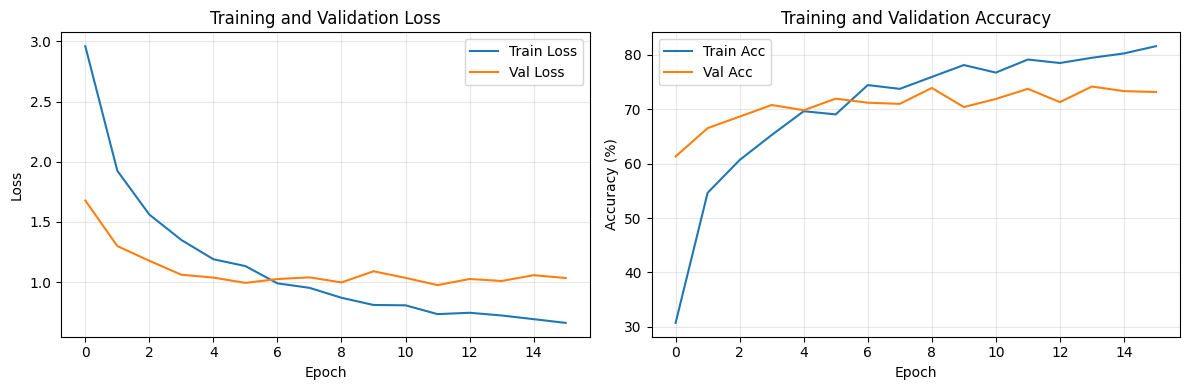


FINAL RESULTS
Test Loss: 0.9564
Test Accuracy: 73.99%
Final Train Accuracy: 81.62%
Final Val Accuracy: 73.19%

SAVED FILES:
   • openclip_vit_l14_dtd_acc_73.99.pth
   • openclip_training_plot_acc_73.99.png
   • Location: /kaggle/working/
SUCCESS: Model file verified: openclip_vit_l14_dtd_acc_73.99.pth
SUCCESS: Plot file verified: openclip_training_plot_acc_73.99.png


In [7]:
# Evaluate on test set
print("\n" + "="*60)
print("EVALUATING MODEL")
print("="*60)

test_loss, test_acc = trainer.evaluate(test_loader)

# Save model in Kaggle working directory
import os

# Create filename with accuracy for easy identification
model_filename = f"openclip_vit_l14_dtd_acc_{test_acc:.2f}.pth"
model_path = os.path.join("/kaggle/working", model_filename)

# Save model state dict
torch.save(model.state_dict(), model_path)
print(f"\nModel saved as '{model_filename}' in /kaggle/working/")

# Check file size
file_size = os.path.getsize(model_path) / (1024 * 1024)
print(f"File size: {file_size:.2f} MB")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

# Save plot in working directory too
plot_filename = f"openclip_training_plot_acc_{test_acc:.2f}.png"
plot_path = os.path.join("/kaggle/working", plot_filename)
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"Training plot saved as '{plot_filename}'")

plt.show()

# Final results summary
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final Val Accuracy: {history['val_acc'][-1]:.2f}%")

# Show saved files
print(f"\nSAVED FILES:")
print(f"   • {model_filename}")
print(f"   • {plot_filename}")
print(f"   • Location: /kaggle/working/")
print("="*60)

# Verify files exist
if os.path.exists(model_path):
    print(f"SUCCESS: Model file verified: {model_filename}")
else:
    print(f"ERROR: Model save failed!")

if os.path.exists(plot_path):
    print(f"SUCCESS: Plot file verified: {plot_filename}")
else:
    print(f"ERROR: Plot save failed!")